#### This notebook will read in Scott England's observation file taken from a TIME-GCM (I think) run, and create a L1 data file in UIUC format. A separate notebook will take this L1 file and turn it into a L2.1 file.

Certain functions in this file may also be useful for the file from Vicki

What is contained in L1 UIUC file:
- ???


In [33]:
%pylab inline
from Scientific.IO.NetCDF import NetCDFFile as Dataset
from datetime import datetime, timedelta
from pyglow import pyglow
from mpl_toolkits.basemap import Basemap
import os
import glob
from scipy.interpolate import griddata
import subprocess
import MIGHTI

reload(MIGHTI)

# Make default figure size bigger
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = (4,3)
matplotlib.rcParams['font.size'] = 8

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [34]:
#ncfn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20151122/England_raw/ICON_MIGHTI_A_ray_UT_1005.00.nc'
ncfn = '/home/bhardin2/MIGHTI/Englandfiles/AB_20151122/England_raw/ICON_MIGHTI_B_ray_UT_1080.00.nc'

########## LOAD CONSTANTS/PARAMETERS ##########
emission_color = 'red' # 'red' or 'green'
day = True

emissions =  MIGHTI.get_emission_constants()
params = MIGHTI.get_instrument_constants()

params['exptime'] =        60.   # sec
params['lam'] =            emissions[emission_color]['lam']
params['frq'] =            emissions[emission_color]['frq']
params['mass'] =           emissions[emission_color]['mass']
if day: # 10% reduction in aperture size during "day", and shorter exposure time
    params['aperture_area'] =  params['aperture_area'] * 0.1
    params['exptime'] =        30.
plot_color = emission_color[0]

j = 1 # Use middle column only, so as not to care about horizontal resolution.

# Whether to include the fact that in the near and far field,
# the line of sight is not horizontal. Set this to True in order
# to run a non-physical simulation to test the inversion. For
# realistic simulations, this should be False.
UNDO_LOCAL_HORZ_PROJECTION = False 
# Whether to include Earth rotation in the forward model. Set this to 
# True to run a non-physical simulation to test the inversion. For
# realistic simulations, this should be False.
UNDO_EARTH_ROTATION = False
###############################################


ncfile = Dataset(ncfn,'r')
vs = ncfile.variables.keys()
vs.sort()
#vs

In [35]:
ray_length = ncfile.variables['MIGHTI_RAY_LENGTH_KM'][0]
emission_along_ray_r = ncfile.variables['MIGHTI_%sLINE_ALONG_RAY_R' % emission_color.upper()][0,:,:,:]
winds_along_ray = ncfile.variables['MIGHTI_LOS_WINDS_ALONG_RAY'][0,:,:,:]
temps_along_ray = ncfile.variables['MIGHTI_TEMPERATURES_ALONG_RAY'][0,:,:,:]
alts_along_ray_start = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_START'][0,:,:,:]
alts_along_ray_end = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_END'][0,:,:,:]
tang_point_along_ray_start = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_START'][0,:,:] # integer index
tang_point_along_ray_end  = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_END'][0,:,:] # integer index
tang_alt_start = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_START'][0,:,:]
tang_alt_end = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_END'][0,:,:]
tang_lat_start = ncfile.variables['MIGHTI_TANGENT_LATITUDES_START'][0,:,:]
tang_lat_end = ncfile.variables['MIGHTI_TANGENT_LATITUDES_END'][0,:,:]
tang_lon_start = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_START'][0,:,:]
tang_lon_end = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_END'][0,:,:]
#icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,0,0,0]
#icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,0,0,0]
icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,]
icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,]
icon_lat_start = ncfile.variables['ICON_LATITUDE_START'][0,] 
icon_lat_end = ncfile.variables['ICON_LATITUDE_END'][0,] 
icon_lon_start = ncfile.variables['ICON_LONGITUDE_START'][0,]
icon_lon_end = ncfile.variables['ICON_LONGITUDE_END'][0,] 
icon_ecef_ram_vector_start = ncfile.variables['ICON_ECEF_RAM_VECTOR_START'][0,:]
icon_ecef_ram_vector_end = ncfile.variables['ICON_ECEF_RAM_VECTOR_END'][0,:]
icon_velocity_start = ncfile.variables['ICON_VELOCITY_START'][0]*1000 # convert from km/s to m/s
icon_velocity_end = ncfile.variables['ICON_VELOCITY_END'][0]*1000 # convert from km/s to m/s
mighti_sza = ncfile.variables['MIGHTI_SZA'][0,:,:,:] # 1000 x 101 x 3

mighti_ecef_vectors_start = ncfile.variables['MIGHTI_ECEF_VECTORS_START'][0,:,:,:]
mighti_ecef_vectors_end = ncfile.variables['MIGHTI_ECEF_VECTORS_END'][0,:,:,:]
mighti_horizontal_component = ncfile.variables['MIGHTI_HORIZONTAL_COMPONENT'][0,:,:,:]
mighti_corotation_vel = ncfile.variables['MIGHTI_COROTATION_VEL'][0,:,:,:]
# Hack to fix a nan issue
mighti_horizontal_component[isnan(mighti_horizontal_component)] = 1.0 # shouldn't make a difference


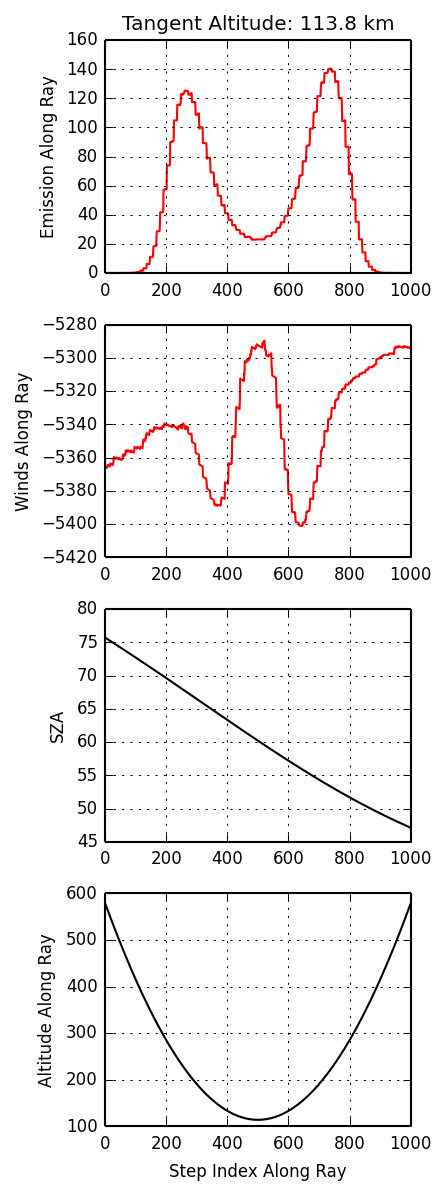

In [36]:
i = 8
j = 1
figure(figsize=(3,8))
subplot(4,1,1)
plot(emission_along_ray_r[:,i,j],'r')
ylabel('Emission Along Ray')
title('Tangent Altitude: %.1f km' % tang_alt_start[i,j])
grid()
subplot(4,1,2)
plot(winds_along_ray[:,i,j],'r')
ylabel('Winds Along Ray')
grid()
subplot(4,1,3)
plot(mighti_sza[:,i,j]*180/pi,'k-')
ylabel('SZA')
grid()
subplot(4,1,4)
plot(alts_along_ray_start[:,i,j],'k')
ylabel('Altitude Along Ray')
xlabel('Step Index Along Ray')
grid()
tight_layout()
#savefig('/home/bhardin2/public_html/parameters_along_ray.png',dpi=200)

## Generate interferogram

In [37]:
nx = params['nx']
ny = shape(winds_along_ray)[1] # number of rows of interferogram
nk = shape(winds_along_ray)[0] # number of steps along ray

tang_alts = tang_alt_start[:,j]

Iraw = np.zeros((ny,nx))

for i in range(ny):
    for k in range(nk):

        amp = emission_along_ray_r[k,i,j]
        vel = winds_along_ray[k,i,j]
        temp = temps_along_ray[k,i,j]
        if UNDO_LOCAL_HORZ_PROJECTION:
            # Take out satellite velocity, then undo
            # horz projection, then put it back in
            look_ecef = (mighti_ecef_vectors_start[i,j,:]+mighti_ecef_vectors_end[i,j,:])/2
            icon_velocity = (icon_velocity_start + icon_velocity_end)/2
            icon_ecef_ram_vector = (icon_ecef_ram_vector_start + icon_ecef_ram_vector_end)/2
            proj_icon_vel = icon_velocity * np.dot(look_ecef,icon_ecef_ram_vector)
            wvel = vel - proj_icon_vel
            wvel = wvel/mighti_horizontal_component[k,i,j]
            vel = wvel + proj_icon_vel
            if isnan(vel):
                raise Exception('%i, %i, %i' % (i,j,k))
        if UNDO_EARTH_ROTATION:
            vel = vel - mighti_corotation_vel[k,i,j]
            
        alt = alts_along_ray_start[k,i,j]

        params['V'] = vel
        params['T'] = temp
        params['I'] = amp

        ccdslice = MIGHTI.interferogram(params)

        Iraw[i,:] += ccdslice
        


<matplotlib.colorbar.Colorbar instance at 0x7f6b5c931950>

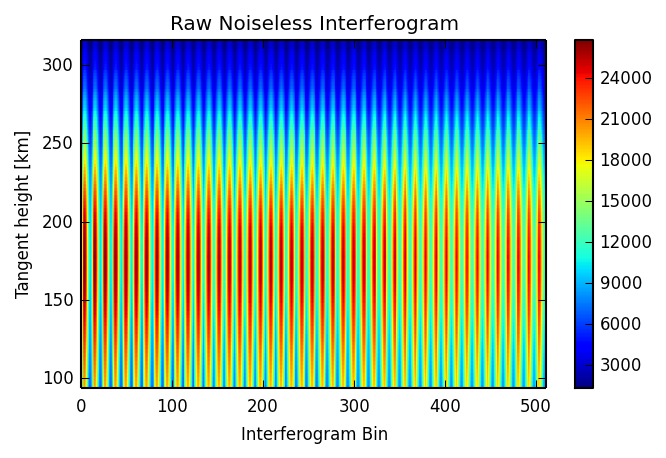

In [38]:
figure(figsize=(5,3))
X,TANH = meshgrid(arange(nx),tang_alts)
pcolormesh(X,TANH, Iraw,cmap='jet')
axis('tight')
xlabel('Interferogram Bin')
ylabel('Tangent height [km]')
title('Raw Noiseless Interferogram')
colorbar()

## Add Noise (skipped for now)

In [39]:
#Inoisy = MIGHTI.add_noise(Iraw, params) # make sure units are right
Inoisy = Iraw.copy()

## L1 processing

In [40]:
Ir = zeros(shape(Inoisy))
Ii = zeros(shape(Inoisy))
for i in range(shape(Inoisy)[0]):
    # Filter with Hann window (in frequency) surrounding the peak
    f = Inoisy[i,:]
    F = np.fft.fft(f)
    N = len(F)
    n = arange(N)
    # Create filter as per Ken Marr's email 2013/10/29
    peaki = abs(F[5:floor(N/2)]).argmax() + 5
    width1 = 20 # width of Hann window
    width2 = 5 # width of plateau
    hann = np.hanning(width1)
    # Create full filter
    H = hstack((zeros(peaki-width1/2-(width2-1)/2), 
                hann[:width1/2], 
                ones(width2), 
                hann[width1/2:], 
                zeros(N - peaki - width1/2 - (width2-1)/2 - 1)))
    ap = hanning(N)
    f = f - f.mean()
    fap = f*ap
    F = np.fft.fft(fap)
    F2 = F * H
    f2 = np.fft.ifft(F2)
    Ir[i,:] = np.real(f2)
    Ii[i,:] = np.imag(f2)

<matplotlib.colorbar.Colorbar instance at 0x7f6b5cb14e18>

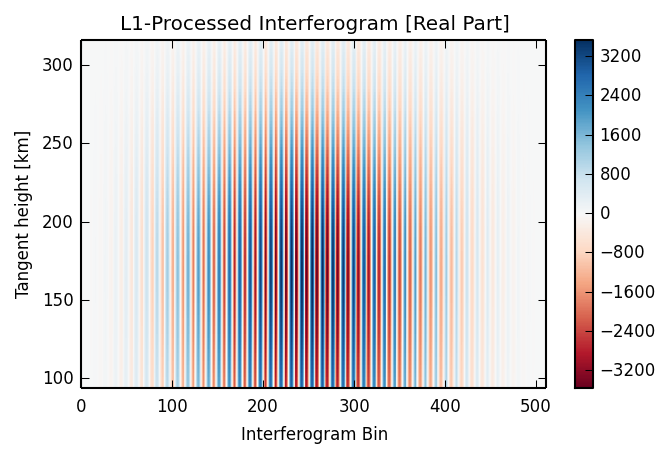

In [41]:
figure(figsize=(5,3))
X,TANH = meshgrid(arange(nx),tang_alts)
pcolormesh(X,TANH, Ir,cmap='RdBu')
axis('tight')

xlabel('Interferogram Bin')
ylabel('Tangent height [km]')
title('L1-Processed Interferogram [Real Part]')
colorbar()

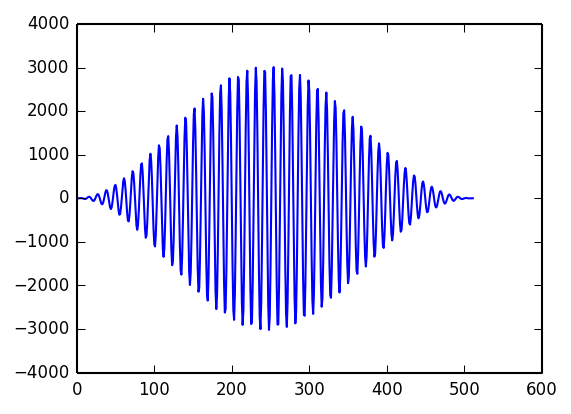

In [42]:
plot(Ir[50,:])

In [20]:
# Save L1 UIUC file
icon_alt = (icon_alt_start + icon_alt_end)/2
L1_UIUC_fn = '/home/bhardin2/MIGHTI/MIGHTI_L1_UIUC_%s_001.npz' % emission_color
np.savez(L1_UIUC_fn,
         Ir=Ir, 
         Ii=Ii, 
         tang_alt_start=  tang_alt_start[:,j],
         tang_alt_end  =  tang_alt_end[:,j],
         tang_lat_start=  tang_lat_start[:,j],
         tang_lat_end  =  tang_lat_end[:,j],
         tang_lon_start=  tang_lon_start[:,j],
         tang_lon_end  =  tang_lon_end[:,j],
         emission_color=  emission_color,
         icon_alt_start=  icon_alt_start,
         icon_alt_end=    icon_alt_end,
         icon_lat_start=  icon_lat_start,
         icon_lat_end=    icon_lat_end,
         icon_lon_start=  icon_lon_start,
         icon_lon_end=    icon_lon_end,
         mighti_ecef_vectors_start=  mighti_ecef_vectors_start[:,j,:],
         mighti_ecef_vectors_end=    mighti_ecef_vectors_end[:,j,:],
         icon_ecef_ram_vector_start= icon_ecef_ram_vector_start,
         icon_ecef_ram_vector_end=   icon_ecef_ram_vector_end,
         icon_velocity_start=        icon_velocity_start,
         icon_velocity_end=          icon_velocity_end,
         datetime_created=           datetime.now(),
         source_files =              [ncfn],
         time         =              0,
         interferometer_start_path = params['startpath'],
         interferometer_end_path =   params['endpath'],)
print L1_UIUC_fn

/home/bhardin2/MIGHTI/MIGHTI_L1_UIUC_red_001.npz


### Obtain truth los winds and save to separate file

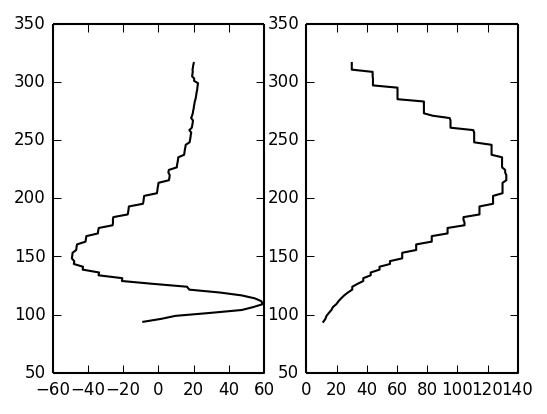

In [21]:
#truthfn = 


# Remove satellite velocity from LoS winds provided
tang_alts = (tang_alt_start[:,j] + tang_alt_end[:,j])/2
mighti_ecef_vectors = (mighti_ecef_vectors_start[:,j,:] + mighti_ecef_vectors_end[:,j,:])/2 # ny by 3
icon_velocity = (icon_velocity_start + icon_velocity_end)/2
icon_ecef_ram_vector = (icon_ecef_ram_vector_start + icon_ecef_ram_vector_end)/2

# Create a column vector with projected satellite velocity. 
# Remember, we are ignoring horizontal extent for now.
proj_icon_vel = zeros(ny)
for i in range(ny):
    look_ecef = mighti_ecef_vectors[i,:] # look direction of this pixel in ECEF
    proj_icon_vel[i] = icon_velocity * np.dot(icon_ecef_ram_vector, look_ecef)


    
truth_winds = zeros(ny)
truth_amps = zeros(ny)
for i in range(ny):
    kstar = tang_point_along_ray_start[i,j]
    truth_winds[i] = winds_along_ray[kstar,i,j] - proj_icon_vel[i]
    truth_winds[i] = truth_winds[i] - mighti_corotation_vel[kstar,i,j]
    truth_amps[i] = emission_along_ray_r[kstar,i,j]
subplot(1,2,1)
plot(truth_winds,tang_alts,'k')
subplot(1,2,2)
plot(truth_amps,tang_alts,'k')


np.savez('/home/bhardin2/MIGHTI/truth_winds_001.npz',tang_alts=tang_alts,truth_winds=truth_winds,\
         truth_amps=truth_amps)


# IGNORE EVERYTHING BELOW HERE

#### First attempt to make a function to do all this stuff. This will make it easier to process a bunch of files at once.

In [67]:
def convert_England_file_to_UIUCL1(ncfn, outfn):
    '''
    This does everything in the notebook above, plus it adds the time
    to each file. Saving the truth winds is optional.
    '''

    ########## LOAD CONSTANTS/PARAMETERS ##########
    emission_color = 'green' # 'red' or 'green'
    day = True

    emissions =  MIGHTI.get_emission_constants()
    params = MIGHTI.get_instrument_constants()

    params['exptime'] =        60.   # sec
    params['lam'] =            emissions[emission_color]['lam']
    params['frq'] =            emissions[emission_color]['frq']
    params['mass'] =           emissions[emission_color]['mass']
    if day: # 10% reduction in aperture size during "day", and shorter exposure time
        params['aperture_area'] =  params['aperture_area'] * 0.1
        params['exptime'] =        30.
    plot_color = emission_color[0]

    j = 1 # Use middle column only, so as not to care about horizontal resolution.

    # Whether to include the fact that in the near and far field,
    # the line of sight is not horizontal. Set this to True in order
    # to run a non-physical simulation to test the inversion. For
    # realistic simulations, this should be False.
    UNDO_LOCAL_HORZ_PROJECTION = False 
    # Whether to include Earth rotation in the forward model. Set this to 
    # True to run a non-physical simulation to test the inversion. For
    # realistic simulations, this should be False.
    UNDO_EARTH_ROTATION = False
    ###############################################


    ncfile = Dataset(ncfn,'r')

    ray_length = ncfile.variables['MIGHTI_RAY_LENGTH_KM'][0]
    emission_along_ray_r = ncfile.variables['MIGHTI_%sLINE_ALONG_RAY_R' % emission_color.upper()][0,:,:,:]
    winds_along_ray = ncfile.variables['MIGHTI_LOS_WINDS_ALONG_RAY'][0,:,:,:]
    temps_along_ray = ncfile.variables['MIGHTI_TEMPERATURES_ALONG_RAY'][0,:,:,:]
    alts_along_ray_start = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_START'][0,:,:,:]
    alts_along_ray_end = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_END'][0,:,:,:]
    tang_point_along_ray_start = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_START'][0,:,:] # integer index
    tang_point_along_ray_end  = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_END'][0,:,:] # integer index
    tang_alt_start = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_START'][0,:,:]
    tang_alt_end = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_END'][0,:,:]
    tang_lat_start = ncfile.variables['MIGHTI_TANGENT_LATITUDES_START'][0,:,:]
    tang_lat_end = ncfile.variables['MIGHTI_TANGENT_LATITUDES_END'][0,:,:]
    tang_lon_start = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_START'][0,:,:]
    tang_lon_end = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_END'][0,:,:]
    #icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,0,0,0]
    #icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,0,0,0]
    icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,]
    icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,]
    icon_lat_start = ncfile.variables['ICON_LATITUDE_START'][0,]
    icon_lat_end = ncfile.variables['ICON_LATITUDE_END'][0,] 
    icon_lon_start = ncfile.variables['ICON_LONGITUDE_START'][0,]
    icon_lon_end = ncfile.variables['ICON_LONGITUDE_END'][0,] 
    icon_ecef_ram_vector_start = ncfile.variables['ICON_ECEF_RAM_VECTOR_START'][0,:]
    icon_ecef_ram_vector_end = ncfile.variables['ICON_ECEF_RAM_VECTOR_END'][0,:]
    icon_velocity_start = ncfile.variables['ICON_VELOCITY_START'][0]*1000 # convert from km/s to m/s
    icon_velocity_end = ncfile.variables['ICON_VELOCITY_END'][0]*1000 # convert from km/s to m/s

    mighti_ecef_vectors_start = ncfile.variables['MIGHTI_ECEF_VECTORS_START'][0,:,:,:]
    mighti_ecef_vectors_end = ncfile.variables['MIGHTI_ECEF_VECTORS_END'][0,:,:,:]
    mighti_horizontal_component = ncfile.variables['MIGHTI_HORIZONTAL_COMPONENT'][0,:,:,:]
    mighti_corotation_vel = ncfile.variables['MIGHTI_COROTATION_VEL'][0,:,:,:]
    # Hack to fix a nan issue
    mighti_horizontal_component[isnan(mighti_horizontal_component)] = 1.0 # shouldn't make a difference


    nx = params['npixelx']
    ny = shape(winds_along_ray)[1] # number of rows of interferogram
    nk = shape(winds_along_ray)[0] # number of steps along ray

    tang_alts = tang_alt_start[:,j]

    Iraw = np.zeros((ny,nx))

    for i in range(ny):
        for k in range(nk):

            amp = emission_along_ray_r[k,i,j]
            vel = winds_along_ray[k,i,j]
            temp = temps_along_ray[k,i,j]
            if UNDO_LOCAL_HORZ_PROJECTION:
                # Take out satellite velocity, then undo
                # horz projection, then put it back in
                look_ecef = (mighti_ecef_vectors_start[i,j,:]+mighti_ecef_vectors_end[i,j,:])/2
                icon_velocity = (icon_velocity_start + icon_velocity_end)/2
                icon_ecef_ram_vector = (icon_ecef_ram_vector_start + icon_ecef_ram_vector_end)/2
                proj_icon_vel = icon_velocity * np.dot(look_ecef,icon_ecef_ram_vector)
                wvel = vel - proj_icon_vel
                wvel = wvel/mighti_horizontal_component[k,i,j]
                vel = wvel + proj_icon_vel
                if isnan(vel):
                    raise Exception('%i, %i, %i' % (i,j,k))
            if UNDO_EARTH_ROTATION:
                vel = vel - mighti_corotation_vel[k,i,j]

            alt = alts_along_ray_start[k,i,j]

            params['V'] = vel
            params['T'] = temp
            params['I'] = amp

            ccdslice = MIGHTI.interferogram(params)

            Iraw[i,:] += ccdslice

    #Inoisy = MIGHTI.add_noise(Iraw, params) # make sure units are right
    Inoisy = Iraw.copy()


    Ir = zeros(shape(Inoisy))
    Ii = zeros(shape(Inoisy))
    for i in range(shape(Inoisy)[0]):
        # Filter with Hann window (in frequency) surrounding the peak
        f = Inoisy[i,:]
        F = np.fft.fft(f)
        N = len(F)
        n = arange(N)
        # Create filter as per Ken Marr's email 2013/10/29
        peaki = abs(F[5:floor(N/2)]).argmax() + 5
        width1 = 20 # width of Hann window
        width2 = 5 # width of plateau
        hann = np.hanning(width1)
        # Create full filter
        H = hstack((zeros(peaki-width1/2-(width2-1)/2), 
                    hann[:width1/2], 
                    ones(width2), 
                    hann[width1/2:], 
                    zeros(N - peaki - width1/2 - (width2-1)/2 - 1)))
        ap = hanning(N)
        f = f - f.mean()
        fap = f*ap
        F = np.fft.fft(fap)
        F2 = F * H
        f2 = np.fft.ifft(F2)
        Ir[i,:] = np.real(f2)
        Ii[i,:] = np.imag(f2)
    
    # Extract time and make up reference
    t = float(ncfn.split('/')[-1].split('_')[-1][:-3])
    dt = datetime(2015,1,1) + timedelta(seconds=t)

    # Save L1 UIUC file
    icon_alt = (icon_alt_start + icon_alt_end)/2

    np.savez(outfn,
             Ir=Ir, 
             Ii=Ii, 
             tang_alt_start=  tang_alt_start[:,j],
             tang_alt_end  =  tang_alt_end[:,j],
             tang_lat_start=  tang_lat_start[:,j],
             tang_lat_end  =  tang_lat_end[:,j],
             tang_lon_start=  tang_lon_start[:,j],
             tang_lon_end  =  tang_lon_end[:,j],
             emission_color=  emission_color,
             icon_alt_start=  icon_alt_start,
             icon_alt_end=    icon_alt_end,
             icon_lat_start=  icon_lat_start,
             icon_lat_end=    icon_lat_end,
             icon_lon_start=  icon_lon_start,
             icon_lon_end=    icon_lon_end,
             mighti_ecef_vectors_start=  mighti_ecef_vectors_start[:,j,:],
             mighti_ecef_vectors_end=    mighti_ecef_vectors_end[:,j,:],
             icon_ecef_ram_vector_start= icon_ecef_ram_vector_start,
             icon_ecef_ram_vector_end=   icon_ecef_ram_vector_end,
             icon_velocity_start=        icon_velocity_start,
             icon_velocity_end=          icon_velocity_end,
             datetime_created=           datetime.now(),
             source_files =              [ncfn],
             time=                       dt,)
    
  

In [8]:
def save_truth_winds(ncfn, truthfn):
    
    ########## LOAD CONSTANTS/PARAMETERS ##########
    # Make sure these are the same as above
    emission_color = 'green' # 'red' or 'green'
    day = True

    emissions =  MIGHTI.get_emission_constants()
    params = MIGHTI.get_instrument_constants()

    params['exptime'] =        60.   # sec
    params['lam'] =            emissions[emission_color]['lam']
    params['frq'] =            emissions[emission_color]['frq']
    params['mass'] =           emissions[emission_color]['mass']
    if day: # 10% reduction in aperture size during "day", and shorter exposure time
        params['aperture_area'] =  params['aperture_area'] * 0.1
        params['exptime'] =        30.
    plot_color = emission_color[0]

    j = 1 # Use middle column only, so as not to care about horizontal resolution.

    # Whether to include the fact that in the near and far field,
    # the line of sight is not horizontal. Set this to True in order
    # to run a non-physical simulation to test the inversion. For
    # realistic simulations, this should be False.
    UNDO_LOCAL_HORZ_PROJECTION = False
    # Whether to include Earth rotation in the forward model. Set this to 
    # True to run a non-physical simulation to test the inversion. For
    # realistic simulations, this should be False.
    # Actually, since L2.1 winds now have corotation removed, we should set this 
    # to TRUE to generate the truth files. 
    UNDO_EARTH_ROTATION = True 
    ###############################################
    
    ncfile = Dataset(ncfn,'r')

    ray_length = ncfile.variables['MIGHTI_RAY_LENGTH_KM'][0]
    emission_along_ray_r = ncfile.variables['MIGHTI_%sLINE_ALONG_RAY_R' % emission_color.upper()][0,:,:,:]
    winds_along_ray = ncfile.variables['MIGHTI_LOS_WINDS_ALONG_RAY'][0,:,:,:]
    temps_along_ray = ncfile.variables['MIGHTI_TEMPERATURES_ALONG_RAY'][0,:,:,:]
    alts_along_ray_start = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_START'][0,:,:,:]
    alts_along_ray_end = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_END'][0,:,:,:]
    tang_point_along_ray_start = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_START'][0,:,:] # integer index
    tang_point_along_ray_end  = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_END'][0,:,:] # integer index
    tang_alt_start = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_START'][0,:,:]
    tang_alt_end = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_END'][0,:,:]
    tang_lat_start = ncfile.variables['MIGHTI_TANGENT_LATITUDES_START'][0,:,:]
    tang_lat_end = ncfile.variables['MIGHTI_TANGENT_LATITUDES_END'][0,:,:]
    tang_lon_start = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_START'][0,:,:]
    tang_lon_end = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_END'][0,:,:]
    #icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,0,0,0]
    #icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,0,0,0]
    icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,]
    icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,]
    icon_lat_start = ncfile.variables['ICON_LATITUDE_START'][0,]
    icon_lat_end = ncfile.variables['ICON_LATITUDE_END'][0,] 
    icon_lon_start = ncfile.variables['ICON_LONGITUDE_START'][0,]
    icon_lon_end = ncfile.variables['ICON_LONGITUDE_END'][0,] 
    icon_ecef_ram_vector_start = ncfile.variables['ICON_ECEF_RAM_VECTOR_START'][0,:]
    icon_ecef_ram_vector_end = ncfile.variables['ICON_ECEF_RAM_VECTOR_END'][0,:]
    icon_velocity_start = ncfile.variables['ICON_VELOCITY_START'][0]*1000 # convert from km/s to m/s
    icon_velocity_end = ncfile.variables['ICON_VELOCITY_END'][0]*1000 # convert from km/s to m/s

    mighti_ecef_vectors_start = ncfile.variables['MIGHTI_ECEF_VECTORS_START'][0,:,:,:]
    mighti_ecef_vectors_end = ncfile.variables['MIGHTI_ECEF_VECTORS_END'][0,:,:,:]
    mighti_horizontal_component = ncfile.variables['MIGHTI_HORIZONTAL_COMPONENT'][0,:,:,:]
    # Hack to fix a nan issue
    mighti_horizontal_component[isnan(mighti_horizontal_component)] = 1.0 # shouldn't make a difference
    mighti_corotation_vel = ncfile.variables['MIGHTI_COROTATION_VEL'][0,:,:,:]
    
    nx = params['npixelx']
    ny = shape(winds_along_ray)[1] # number of rows of interferogram
    nk = shape(winds_along_ray)[0] # number of steps along ray

    # Obtain truth winds and save to separate file
    # Remove satellite velocity from LoS winds provided
    tang_alts = (tang_alt_start[:,j] + tang_alt_end[:,j])/2
    mighti_ecef_vectors = (mighti_ecef_vectors_start[:,j,:] + mighti_ecef_vectors_end[:,j,:])/2 # ny by 3
    icon_velocity = (icon_velocity_start + icon_velocity_end)/2
    icon_ecef_ram_vector = (icon_ecef_ram_vector_start + icon_ecef_ram_vector_end)/2

    # Create a column vector with projected satellite velocity. 
    # Remember, we are ignoring horizontal extent for now.
    proj_icon_vel = zeros(ny)
    for i in range(ny):
        look_ecef = mighti_ecef_vectors[i,:] # look direction of this pixel in ECEF
        proj_icon_vel[i] = icon_velocity * np.dot(icon_ecef_ram_vector, look_ecef)
    # Create column vector with Earth rotation. (Read scott's file)

    truth_winds = zeros(ny)
    truth_amps = zeros(ny)
    for i in range(ny):
        kstar = tang_point_along_ray_start[i,j]
        truth_winds[i] = winds_along_ray[kstar,i,j] - proj_icon_vel[i]
        if UNDO_EARTH_ROTATION: # Remove earth rotation from the "truth"
            truth_winds[i] = truth_winds[i] - mighti_corotation_vel[kstar,i,j]
        truth_amps[i] = emission_along_ray_r[kstar,i,j]
    subplot(1,2,1)
    plot(truth_winds,tang_alts,'k')
    subplot(1,2,2)
    plot(truth_amps,tang_alts,'k')
    
    ncfile.close()


    np.savez(truthfn,tang_alts=tang_alts,truth_winds=truth_winds,\
             truth_amps=truth_amps)


In [10]:
Afns = glob.glob('/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_*.nc')
Afns.sort()
Bfns = glob.glob('/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_B_*.nc')
Bfns.sort()
Afns

['/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1005.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1035.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_105.000.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1065.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1095.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1125.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1155.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1185.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1215.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/England_raw/ICON_MIGHTI_A_ray_UT_1245.00.nc',
 '/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/E

In [ ]:
for fn in concatenate((Afns,Bfns)):
    path = '/'.join(fn.split('/')[:-2])
    namestub = '.'.join(fn.split('/')[-1].split('.')[:-1])
    outfn = '%s/UIUCL1/%s.npz' % (path,namestub)
    print outfn
    convert_England_file_to_UIUCL1(fn,outfn)

/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/UIUCL1/ICON_MIGHTI_A_ray_UT_1005.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/UIUCL1/ICON_MIGHTI_A_ray_UT_1035.00.npz

/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1005.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1035.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_105.000.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1065.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1095.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1125.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1155.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1185.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1215.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1245.00.npz
/home/bhardin2/MIGHTI/Englandfiles/AB_20150521/Truth_raw/ICON_MIGHTI_A_ray_UT_1275.00.npz
/home/bhar

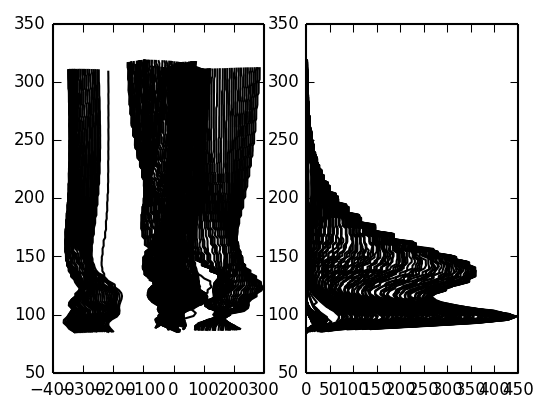

In [11]:
for fn in concatenate((Afns,Bfns)):
    path = '/'.join(fn.split('/')[:-2])
    namestub = '.'.join(fn.split('/')[-1].split('.')[:-1])
    outfn = '%s/Truth_raw/%s.npz' % (path,namestub)
    print outfn
    save_truth_winds(fn,outfn)

### Other analyses

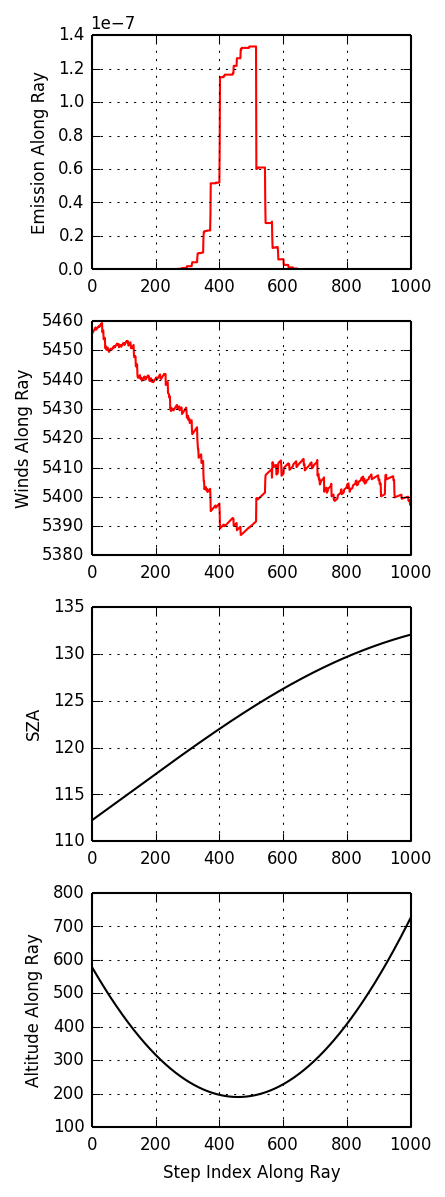

In [52]:
i = 40
j = 1
figure(figsize=(3,8))
subplot(4,1,1)
plot(emission_along_ray_r[:,i,j],'r')
ylabel('Emission Along Ray')
grid()
subplot(4,1,2)
plot(winds_along_ray[:,i,j],'r')
ylabel('Winds Along Ray')
grid()
subplot(4,1,3)
plot(mighti_sza[:,i,j]*180/pi,'k-')
ylabel('SZA')
grid()
subplot(4,1,4)
plot(alts_along_ray_start[:,i,j],'k')
ylabel('Altitude Along Ray')
xlabel('Step Index Along Ray')
grid()
tight_layout()
#savefig('/home/bhardin2/public_html/parameters_along_ray.png',dpi=200)

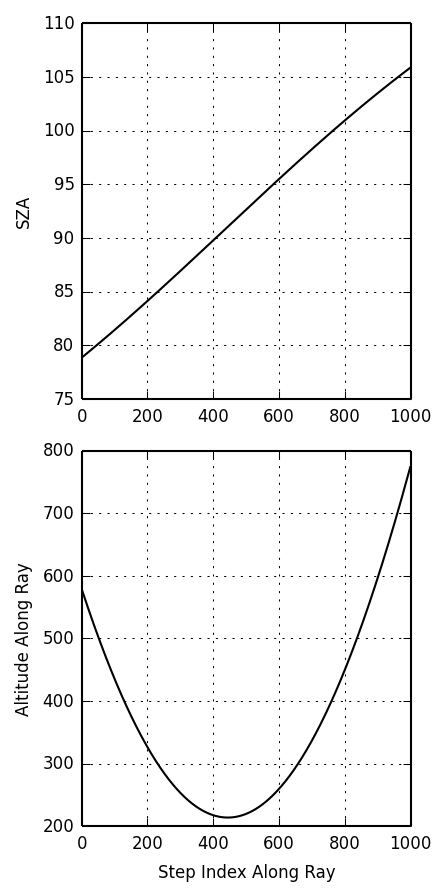

In [48]:
i = 50
j = 1
figure(figsize=(3,6))
subplot(2,1,1)
plot(mighti_sza[:,i,j]*180/pi,'k-')
ylabel('SZA')
grid()

subplot(2,1,2)
plot(alts_along_ray_start[:,i,j],'k')
ylabel('Altitude Along Ray')
xlabel('Step Index Along Ray')
grid()
tight_layout()

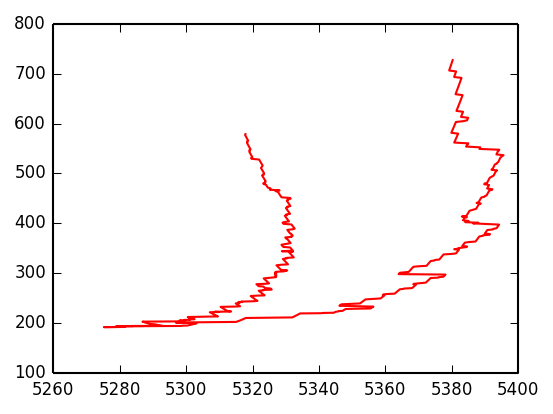

In [27]:
plot(winds_along_ray[:,i,j],alts_along_ray_start[:,i,j],'r-')


## Test Scott's horizontal projection values vs mine

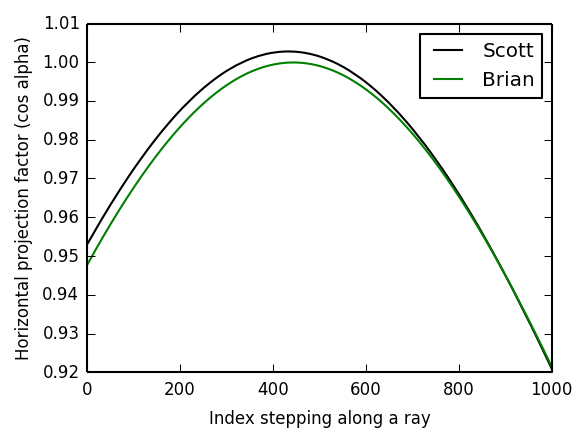

In [28]:
alts_along_ray = (alts_along_ray_end + alts_along_ray_start)/2

# Grab the matrix for the middle column
j = 1
H = mighti_horizontal_component[:,:,j] # (1000 steps x 101 rows)
# Let's only look at the 50th row ( a single ray )
i = 50
b_scott = H[:,i] 
# To calculate it my way, I need Earth radius, icon alt, altitude, and look angle
#(RE+icon_alt)/(RE+r) * sin(th)
theta = MIGHTI.tanht2angle(tang_alts, icon_alt)
th = theta[i]
RE = 6378.
r = alts_along_ray[:,i,j]
b_brian = (RE+icon_alt)/(RE+r) * sin(th)
plot(b_scott,'k',label='Scott')
plot(b_brian,'g',label='Brian')
xlabel('Index stepping along a ray')
ylabel('Horizontal projection factor (cos alpha)')
legend(loc='best')
#savefig('/home/bhardin2/public_html/MIGHTI/horizontal_projection_factor.png',dpi=200)

## Test ECEF to WGS84 conversion with Scott's variables

In [29]:
import ICON
reload(ICON)

icon_ecef_vector_x_start = ncfile.variables['ICON_ECEF_VECTOR_X_START'][0]
icon_ecef_vector_y_start = ncfile.variables['ICON_ECEF_VECTOR_Y_START'][0]
icon_ecef_vector_z_start = ncfile.variables['ICON_ECEF_VECTOR_Z_START'][0]

icon_latlonalt = ICON.ecef_to_wgs84([icon_ecef_vector_x_start, icon_ecef_vector_y_start,\
                                     icon_ecef_vector_z_start])
print icon_latlonalt

print [icon_lat_start, icon_lon_start, icon_alt_start]

[  25.03812371  251.89531608  578.80599949]
[25.038126, 251.89531, 578.80566]


In [30]:
#vs

In [31]:
ray_length = ncfile.variables['MIGHTI_RAY_LENGTH_KM'][0]
emission_along_ray_r = ncfile.variables['MIGHTI_%sLINE_ALONG_RAY_R' % emission_color.upper()][0,:,:,:]
winds_along_ray = ncfile.variables['MIGHTI_LOS_WINDS_ALONG_RAY'][0,:,:,:]
temps_along_ray = ncfile.variables['MIGHTI_TEMPERATURES_ALONG_RAY'][0,:,:,:]
alts_along_ray_start = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_START'][0,:,:,:]
alts_along_ray_end = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_END'][0,:,:,:]
lats_along_ray_start = ncfile.variables['MIGHTI_WGS84_LATITUDES_ALONG_RAY_START'][0,:,:,:]
lons_along_ray_start = ncfile.variables['MIGHTI_WGS84_LONGITUDES_ALONG_RAY_START'][0,:,:,:]

tang_point_along_ray_start = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_START'][0,:,:] # integer index
tang_point_along_ray_end  = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_END'][0,:,:] # integer index
tang_alt_start = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_START'][0,:,:]
tang_alt_end = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_END'][0,:,:]
tang_lat_start = ncfile.variables['MIGHTI_TANGENT_LATITUDES_START'][0,:,:]
tang_lat_end = ncfile.variables['MIGHTI_TANGENT_LATITUDES_END'][0,:,:]
tang_lon_start = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_START'][0,:,:]
tang_lon_end = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_END'][0,:,:]
#icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,0,0,0]
#icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,0,0,0]
icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0]
icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0]
icon_lat_start = ncfile.variables['ICON_LATITUDE_START'][0] # I think something's wrong here. Only using 1st element
icon_lat_end = ncfile.variables['ICON_LATITUDE_END'][0] # I think something's wrong here. Only using 1st element
icon_lon_start = ncfile.variables['ICON_LONGITUDE_START'][0] # I think something's wrong here. Only using 1st element
icon_lon_end = ncfile.variables['ICON_LONGITUDE_END'][0] # I think something's wrong here. Only using 1st element
mighti_ecef_vectors_start = ncfile.variables['MIGHTI_ECEF_VECTORS_START'][0,:,:,:]
mighti_ecef_vectors_end = ncfile.variables['MIGHTI_ECEF_VECTORS_END'][0,:,:,:]

mighti_wgs84_altitudes_along_ray_start = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_START'][0,:,:,:]

In [32]:
i = 50
j = 1
alts = alts_along_ray_start[:,i,j]
lats = lats_along_ray_start[:,i,j]
lons = lons_along_ray_start[:,i,j]
talt = tang_alt_start[i,j]
tlat = tang_lat_start[i,j]
tlon = tang_lon_start[i,j]

print 'Tangent location according to file [lat, lon, alt]:'
print [tlat,tlon,talt]

print 'Tangent location calculated from ECEF look directions in file [lat, lon, alt]:'
# Start with ICON_ALTITUDE_START, (and LAT and LON) and MIGHTI_ECEF_VECTORS_START
lookxyz = mighti_ecef_vectors_start[i,j,:]
icon_latlonalt = array([icon_lat_start, icon_lon_start, icon_alt_start])
icon_xyz = ICON.wgs84_to_ecef(icon_latlonalt)
v,e,n = ICON.ecef_to_ven(icon_latlonalt, lookxyz)
ze = arccos(v)*180/pi
az = arctan2(e,n)*180/pi
tang_latlonalt = ICON.tangent_point(icon_latlonalt, az, ze)
print tang_latlonalt


print 'Tangent location calculated from ECEF look directions in file (alternative way)'
lookxyz = mighti_ecef_vectors_start[i,j,:]
icon_latlonalt = array([icon_lat_start, icon_lon_start, icon_alt_start])
icon_xyz = ICON.wgs84_to_ecef(icon_latlonalt)
xyz = icon_xyz.copy()
step = 1.0 # km
maxiters = 100000
iters = 0
dalt = -inf
while(dalt < 0 and iters < maxiters):
    old_latlonalt = ICON.ecef_to_wgs84(xyz)
    old_alt = old_latlonalt[2]
    iters += 1
    xyz = xyz + step*lookxyz
    new_latlonalt = ICON.ecef_to_wgs84(xyz)
    new_alt = new_latlonalt[2]
    dalt = new_alt - old_alt
print new_latlonalt

    

Tangent location according to file [lat, lon, alt]:
[39.848401869670191, 265.40911865234375, 213.88197]
Tangent location calculated from ECEF look directions in file [lat, lon, alt]:
[  39.86056298  265.42312617  213.88144813]
Tangent location calculated from ECEF look directions in file (alternative way)
[  39.86795176  265.43164168  213.88149399]


In [33]:
dlat = tang_latlonalt[0] - tlat
print dlat
dlatkm = 111*dlat
print dlatkm

0.0121611065375
1.34988282567


In [34]:
dlon = tang_latlonalt[1] - (tlon)
print dlon
dlonkm = 111*dlon
print dlonkm

0.0140075137314
1.55483402419


In [35]:
dalt = tang_latlonalt[2] - talt
print dalt

-0.000525133379597


## Check corrections

In [36]:
mighti_corotation_vel = ncfile.variables['MIGHTI_COROTATION_VEL'][0,:,:,:]
mighti_los_sc_vel = ncfile.variables['MIGHTI_LOS_SC_VEL'][0,:,:]
mighti_horizontal_component = ncfile.variables['MIGHTI_HORIZONTAL_COMPONENT'][0,:,:,:]

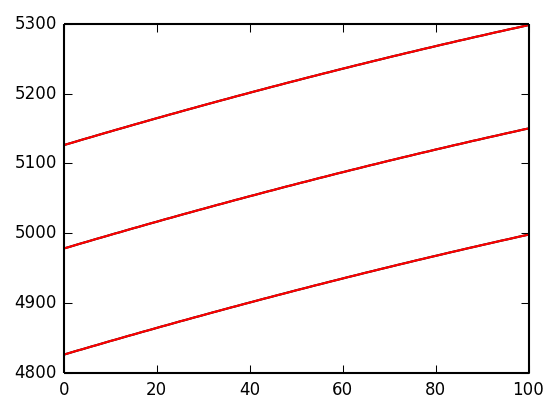

In [37]:
j = 0
# From file:
losfile = mighti_los_sc_vel

# Calculated, copied from L2.1 processing
# Create a column vector with projected satellite velocity. Remember, we are ignoring horizontal extent for now.
mighti_ecef_vectors_start = ncfile.variables['MIGHTI_ECEF_VECTORS_START'][0,:,:,:]
mighti_ecef_vectors = mighti_ecef_vectors_start[:,j,:]

proj_icon_vel = zeros(shape(losfile))
for i in range(ny):
    for j in range(shape(losfile)[1]):
        look_ecef = mighti_ecef_vectors_start[i,j,:] # look direction of this pixel in ECEF
        proj_icon_vel[i,j] = icon_velocity * np.dot(icon_ecef_ram_vector_start, look_ecef)

plot(losfile,'k')
plot(proj_icon_vel,'r')

In [38]:
# Check against Scott's example
print 'File says projected ICON velocity for [0,0] ray is %.2f' % losfile[0,0]
print 'Other parameters in file that I will use:'
print 'ICON ram vector ecef:         %s' % icon_ecef_ram_vector
print 'MIGHTI [0,0] ray vector ecef: %s' % mighti_ecef_vectors_start[0,0]
print 'ICON velocity:                %f' % icon_velocity_start
print 'And the calculation is ICON velocity * dot(a,b) where a,b are the two vectors above'
print 'projected ICON velocity: %.2f' % (icon_velocity_start*dot(icon_ecef_ram_vector, mighti_ecef_vectors_start[0,0]))


File says projected ICON velocity for [0,0] ray is 4825.91
Other parameters in file that I will use:
ICON ram vector ecef:         [ 0.96298941 -0.21525293  0.16129874]
MIGHTI [0,0] ray vector ecef: [ 0.68194085  0.47591326  0.55539465]
ICON velocity:                7571.499825
And the calculation is ICON velocity * dot(a,b) where a,b are the two vectors above
projected ICON velocity: 4874.87


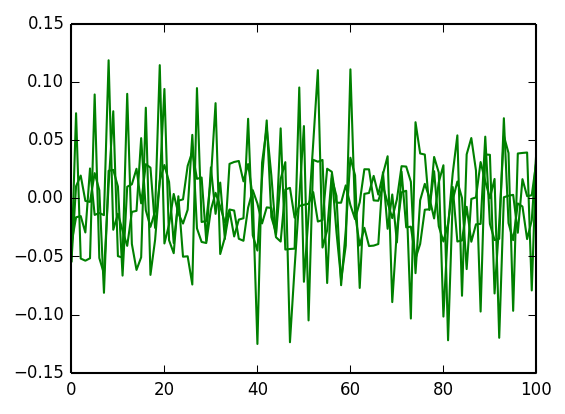

In [39]:
plot(proj_icon_vel-losfile, 'g')

<matplotlib.colorbar.Colorbar instance at 0x7f4ddcbdad40>

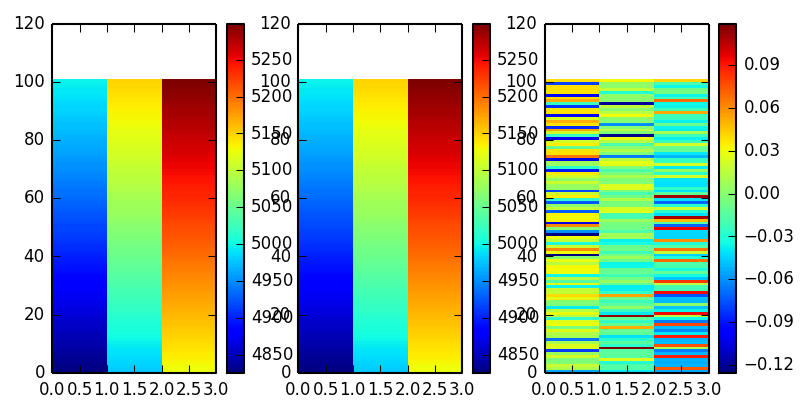

In [40]:

figure(figsize=(6,3))
subplot(1,3,1)
pcolor(mighti_los_sc_vel)
colorbar()
subplot(1,3,2)
pcolor(proj_icon_vel)
colorbar()
subplot(1,3,3)
pcolor(proj_icon_vel - mighti_los_sc_vel)
colorbar()


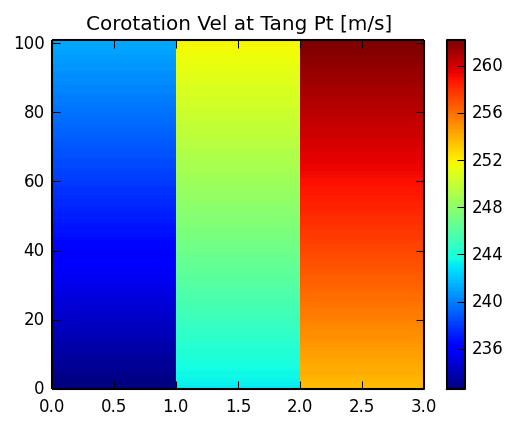

In [41]:
# Earth rotation
mighti_corotation_vel_tangpoint = zeros(shape(mighti_corotation_vel)[1:3])
for i in range(ny):
    for j in range(shape(losfile)[1]):
        kstar = tang_point_along_ray_start[i,j]
        mighti_corotation_vel_tangpoint[i,j] = mighti_corotation_vel[kstar,i,j]
pcolor(mighti_corotation_vel_tangpoint)
axis('tight')
colorbar()
title('Corotation Vel at Tang Pt [m/s]')

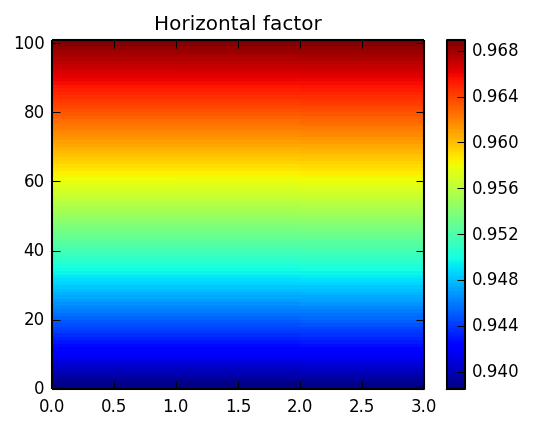

In [42]:

mighti_horizontal_component_slice = zeros(shape(mighti_horizontal_component)[1:3])
for i in range(ny):
    for j in range(shape(losfile)[1]):
        #kstar = tang_point_along_ray_start[i,j]
        kstar = 10
        mighti_horizontal_component_slice[i,j] = mighti_horizontal_component[kstar,i,j]
pcolor(mighti_horizontal_component_slice)
axis('tight')
colorbar()
title('Horizontal factor')